 data preprocessing & baseline model

Model: Logistic Regression
Accuracy: 0.7143
ROC AUC: 0.8230
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       100
           1       0.61      0.52      0.56        54

    accuracy                           0.71       154
   macro avg       0.68      0.67      0.67       154
weighted avg       0.71      0.71      0.71       154



Model: Random Forest
Accuracy: 0.7468
ROC AUC: 0.8181
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       100
           1       0.65      0.61      0.63        54

    accuracy                           0.75       154
   macro avg       0.72      0.72      0.72       154
weighted avg       0.74      0.75      0.75       154



Model: XGBoost
Accuracy: 0.7338
ROC AUC: 0.8052
              precision    recall  f1-score   support

           0       0.79      0.80      0.80       100
           1       0.62      0.61      0.62        54

    accuracy    

C:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:56:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model: SVM
Accuracy: 0.7532
ROC AUC: 0.7919
              precision    recall  f1-score   support

           0       0.80      0.83      0.81       100
           1       0.66      0.61      0.63        54

    accuracy                           0.75       154
   macro avg       0.73      0.72      0.72       154
weighted avg       0.75      0.75      0.75       154



Model: Neural Network
Accuracy: 0.7078
ROC AUC: 0.8011
              precision    recall  f1-score   support

           0       0.77      0.78      0.78       100
           1       0.58      0.57      0.58        54

    accuracy                           0.71       154
   macro avg       0.68      0.68      0.68       154
weighted avg       0.71      0.71      0.71       154





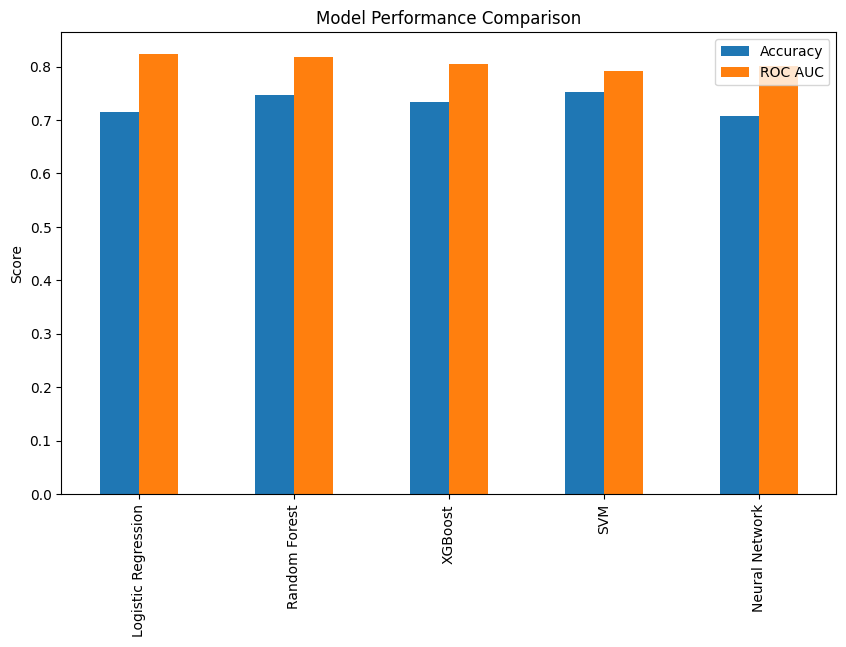

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# Load dataset
df = pd.read_csv("C:/Users/dell/Documents/GitHub/Diabetes-Prediction-Model/Data/Raw/diabetes.csv")

# Splitting data into features and target
X = df.drop(columns=["Outcome"])
y = df["Outcome"]

# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardizing features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "SVM": SVC(probability=True),
    "Neural Network": MLPClassifier(max_iter=1000)
}

# Train and evaluate models
model_performance = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else None
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    
    model_performance[name] = {
        "Accuracy": accuracy,
        "Classification Report": report,
        "Confusion Matrix": cm,
        "ROC AUC": roc_auc
    }
    
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}" if roc_auc is not None else "ROC AUC: N/A")
    print(report)
    print("\n")

# Compare performance
performance_df = pd.DataFrame({model: [metrics["Accuracy"], metrics["ROC AUC"]] for model, metrics in model_performance.items()}, index=["Accuracy", "ROC AUC"])
performance_df.T.plot(kind='bar', figsize=(10, 6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.show()


Tuning the Random Forest model since it performed well in accuracy and AUC.
We'll use GridSearchCV to optimize hyperparameters like:

n_estimators (Number of trees)
max_depth (Tree depth)
min_samples_split (Min samples to split a node)
min_samples_leaf (Min samples in leaf node)

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the model
rf_model = RandomForestClassifier(random_state=42)

# Grid search with cross-validation
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score


Fitting 5 folds for each of 81 candidates, totalling 405 fits


({'max_depth': 5,
  'min_samples_leaf': 1,
  'min_samples_split': 5,
  'n_estimators': 50},
 np.float64(0.839156976744186))

Retraining the Random Forest model using these optimal hyperparameters above on the full training set and evaluating it on the test set

Training the model with:

max_depth=5
min_samples_leaf=1
min_samples_split=5
n_estimators=50

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Best hyperparameters from GridSearchCV
best_params = {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}

# Train Random Forest with best parameters
optimized_rf = RandomForestClassifier(**best_params, random_state=42)
optimized_rf.fit(X_train, y_train)

# Predictions
y_pred = optimized_rf.predict(X_test)
y_proba = optimized_rf.predict_proba(X_test)[:, 1]

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
classification_rep = classification_report(y_test, y_pred)

accuracy, roc_auc, classification_rep


(0.7207792207792207,
 np.float64(0.8085185185185186),
 '              precision    recall  f1-score   support\n\n           0       0.75      0.85      0.80       100\n           1       0.63      0.48      0.55        54\n\n    accuracy                           0.72       154\n   macro avg       0.69      0.67      0.67       154\nweighted avg       0.71      0.72      0.71       154\n')

In [ ]:
Feature Engineering:

C:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:18:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


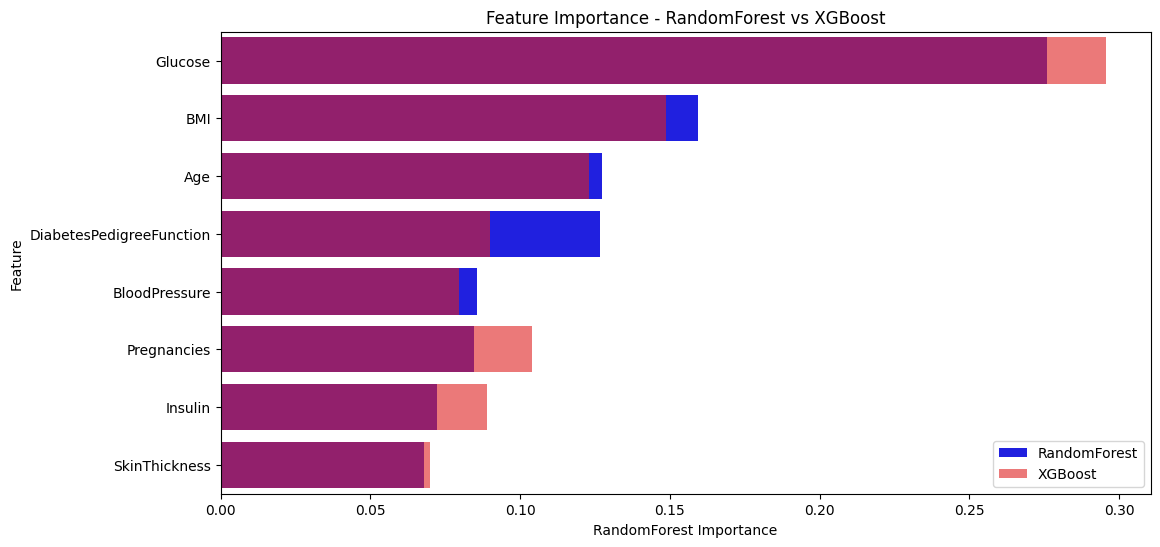

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Assuming X_train and y_train are already defined
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Get feature importance
rf_importance = rf_model.feature_importances_
xgb_importance = xgb_model.feature_importances_

# Create a dataframe for visualization
feature_names = X_train.columns
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "RandomForest Importance": rf_importance,
    "XGBoost Importance": xgb_importance
}).sort_values(by="RandomForest Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x="RandomForest Importance", y="Feature", data=importance_df, label="RandomForest", color="blue")
sns.barplot(x="XGBoost Importance", y="Feature", data=importance_df, label="XGBoost", color="red", alpha=0.6)
plt.legend()
plt.title("Feature Importance - RandomForest vs XGBoost")
plt.show()


Dropping "SkinThickness" to improve model's performance 

In [5]:
# Drop 'SkinThickness' from training and test sets
X_train = X_train.drop(columns=['SkinThickness'])
X_test = X_test.drop(columns=['SkinThickness'])

# Retrain the Random Forest model (or other models you're using)
rf = RandomForestClassifier(**best_params)  # Using best hyperparameters from GridSearch
rf.fit(X_train, y_train)

# Evaluate the updated model
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
classification_rep = classification_report(y_test, y_pred)

print(f"Updated Model Accuracy: {accuracy:.4f}")
print(f"Updated ROC AUC: {roc_auc:.4f}")
print("Updated Classification Report:\n", classification_rep)


Updated Model Accuracy: 0.7662
Updated ROC AUC: 0.8178
Updated Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.87      0.83       100
           1       0.70      0.57      0.63        54

    accuracy                           0.77       154
   macro avg       0.75      0.72      0.73       154
weighted avg       0.76      0.77      0.76       154

